In [34]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
#euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))



Implementing the $G_\epsilon$ score for trade off measurements. 
The score is given by :
$$ G_\epsilon = \alpha \mu(D_{s},D_{p})+\beta \delta( D_{s},D_{p})$$
where
$$\mu (D_{s},D_{p})= \dfrac{\left || \Phi_{k}(D_{s})-\Phi_{k}(D_{p})\right||_{2}}{m(m-1)/2} $$
$$ \delta(D_{s},D_{p})= \dfrac {1}{mKL} \sum _{m}\sum_{K} \sum_{L} || acc^{l}(M_{X_{i},D_{s}}^{k})-acc^{l}(M_{X_{i},D_{p}}^{k})  ||_{2}$$

Implementing $\Phi_{k}$ correlation index at first

In [35]:
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from phik import report

In [3]:
#Toy data with Iris original and synthetic dataset
D_p=pd.read_csv('iris.csv')
D_p.drop('Unnamed: 0',axis=1,inplace=True)
D_s=pd.read_csv('iris_synthetic.csv')
D_s.drop('Unnamed: 0',axis=1,inplace=True)
data=D_p

In [4]:
#Data types in the next 
data_types={'sepal_length': 'interval', 
            'sepal_width': 'interval', 
            'petal_length': 'interval', 
            'petal_width': 'interval', 
            'species': 'categorical'}
interval_cols = [col for col, v in data_types.items() if v=='interval' and col in data.columns]
categorical_cols = [col for col, v in data_types.items() if v=='categorical' and col in data.columns]

In [5]:
#bin the interval variables
# data_binned, binning_dict = bin_data(data, cols=interval_cols, retbins=True)

In [6]:
# # plot each variable pair
# plt.rc('text', usetex=False)

# n=0
# for i in range(len(data.columns)):
#     n=n+i
    
# ncols=3
# nrows=int(np.ceil(n/ncols))
# fig, axes = plt.subplots(nrows, ncols, figsize=(15,4*nrows))
# ndecimals = 0

# for i, comb in enumerate(itertools.combinations(data_binned.columns.values, 2)):
    
#     c = int(i%ncols)
#     r = int((i-c)/ncols )

#     # get data
#     c0, c1 = comb
#     datahist = data_binned.groupby([c0,c1])[c0].count().to_frame().unstack().fillna(0)
#     datahist.columns = datahist.columns.droplevel()
    
#     # plot data
#     img = axes[r][c].pcolormesh(datahist.values, edgecolor='w', linewidth=1)
    
#     # axis ticks and tick labels
#     if c0 in binning_dict.keys():
#         ylabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c0][i][0], binning_dict[c0][i][1])
#                    for i in range(len(binning_dict[c0]))]
#     else:
#         ylabels = datahist.index

#     if c1 in binning_dict.keys():        
#         xlabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c1][i][0], binning_dict[c1][i][1])
#                     for i in range(len(binning_dict[c1]))]
#     else:
#         xlabels = datahist.columns
    
#     # axis labels
#     axes[r][c].set_yticks(np.arange(len(ylabels)) + 0.5)
#     axes[r][c].set_xticks(np.arange(len(xlabels)) + 0.5)
#     axes[r][c].set_xticklabels(xlabels, rotation='vertical')
#     axes[r][c].set_yticklabels(ylabels, rotation='horizontal')    
#     axes[r][c].set_xlabel(datahist.columns.name)
#     axes[r][c].set_ylabel(datahist.index.name)    
#     axes[r][c].set_title('data')
    
# plt.tight_layout()

# global_correlation, global_labels = data.global_phik(interval_cols=interval_cols)
# plot_correlation_matrix(global_correlation, x_labels=[''], y_labels=global_labels, 
#                         vmin=0, vmax=1, figsize=(3.5,4),
#                         color_map='Reds', title=r'$g_k$',
#                         fontsize_factor=1.5)
# plt.tight_layout()

# rep = report.correlation_report(data, significance_threshold=3, correlation_threshold=0.5)



In [7]:
#Matrix
phik_DS=D_s.phik_matrix(interval_cols)
phik_DP=D_p.phik_matrix(interval_cols)

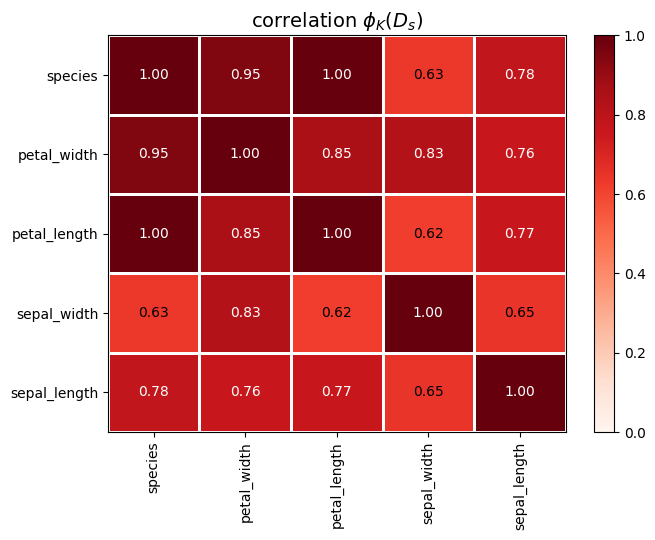

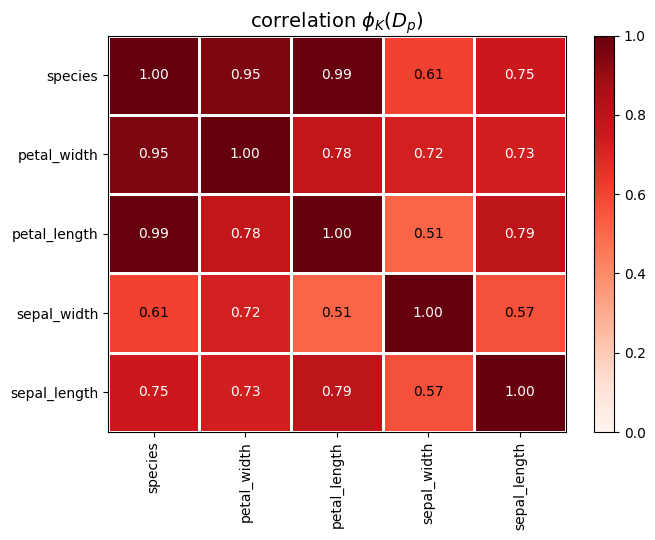

In [8]:
plot_correlation_matrix(phik_DS.values, x_labels=phik_DS.columns, y_labels=phik_DS.index, 
                        vmin=0, vmax=1, color_map='Reds', title=r'correlation $\phi_K (D_{s})$',
                        figsize=(7,5.5))
plt.tight_layout()

plot_correlation_matrix(phik_DP.values, x_labels=phik_DP.columns, y_labels=phik_DP.index, 
                        vmin=0, vmax=1, color_map='Reds', title=r'correlation $\phi_K (D_{p})$',
                        figsize=(7,5.5))
plt.tight_layout()

Getting $\mu (D_{s},D_{p})$

In [9]:
#euclidean norm of the difference between the two matrices
diff = np.linalg.norm(phik_DS-phik_DP)
m=phik_DS.shape[0]
mu = diff/(m*(m-1)/2)
print(f'The mu is: {mu}')

The mu is: 0.027344936174705486


Getting $\delta (D_{p},D_{s})$

In [10]:
from Project.Metrics.Utility.utility import DataPreProcessor
from Project.Metrics.Utility.utility import train_evaluate_model

In [19]:
# m is the number of ML tasks (features in this scenario)
# K is the number ML models 
# L is the number of scoring functions

#Using the class from https://github.com/Vicomtech/STDG-evaluation-metrics (By Mikel Hernandez)
#l = {accuracy,precision,recall,f1,roc_auc}
#K = {DT,KNN,MLP,RF,SVM}

#For categorical columns
#Initialize a 3D matrix with mxKxL
K = 5
L = 4
m = len(categorical_cols)
matrix = np.zeros((K,L,m))
#Getting a sample of 80% of the data
data_train = D_s.sample(frac=0.8, random_state=1)
data_test = D_s.drop(data_train.index)

#only iterate over the categorical columns
for id,i in enumerate(categorical_cols):
    #The i-th Ml task corresponds to the i-th column in the dataset, 
    #and the label for prediction 
    target_col = i
    model_cols = [col for col in data.columns if col != target_col]
    #new categorical and numerical cols without the target value
    interval_cols_ = [col for col, v in data_types.items() if v=='interval' and col != target_col]
    categorical_cols_ = [col for col, v in data_types.items() if v=='categorical' and col != target_col]

    if len(categorical_cols_) == 0:
        categorical_cols_ = None
    if len(interval_cols_) == 0:
        interval_cols_ = None
    print(f'Model cols: {model_cols}')
    
    print(f'Target column: {target_col}')
    #Model cols are every column except the target column
    target = data[target_col]
    categories = [np.array(range(len(data[col].unique()))) for col in categorical_cols]
   
    data_preprocessor = DataPreProcessor(categorical_cols_, interval_cols_,
                                         categories)
    
    x_train = data_preprocessor.preprocess_train_data(data_train.loc[:, model_cols])
    y_train = data_train.loc[:, target_col]
    
    x_test = data_preprocessor.preprocess_test_data(data_test.loc[:, model_cols])
    y_test = data_test.loc[:, target_col]
    
    #training RF
    print('Training RF')
    rf_results = train_evaluate_model('RF', x_train, y_train, x_test, y_test)
    rf_results.drop('model',axis=1,inplace=True)
    print(rf_results)
    #training kN
    print('Training KNN')
    knn_results = train_evaluate_model('KNN', x_train, y_train, x_test, y_test)
    knn_results.drop('model',axis=1,inplace=True)
    #training DT
    print('Training DT')
    dt_results = train_evaluate_model('DT', x_train, y_train, x_test, y_test)
    dt_results.drop('model',axis=1,inplace=True)
    #training SVM
    print('Training SVM')
    svm_results = train_evaluate_model('SVM', x_train, y_train, x_test, y_test)
    svm_results.drop('model',axis=1,inplace=True)
    #training MLP
    print('Training MLP')
    mlp_results = train_evaluate_model('MLP', x_train, y_train, x_test, y_test)
    mlp_results.drop('model',axis=1,inplace=True)
    matrix[0,:,id]=rf_results.values
    matrix[1,:,id]=knn_results.values
    matrix[2,:,id]=dt_results.values
    matrix[3,:,id]=svm_results.values
    matrix[4,:,id]=mlp_results.values
    
# matrix_Dp = matrix
# matrix_Ds = matrix

Model cols: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Target column: species
Training RF


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


['virginica' 'versicolor' 'versicolor' 'setosa' 'versicolor' 'virginica'
 'virginica' 'setosa' 'setosa' 'versicolor' 'virginica' 'versicolor'
 'virginica' 'versicolor' 'setosa' 'virginica' 'setosa' 'setosa'
 'versicolor' 'versicolor' 'versicolor' 'virginica' 'virginica'
 'virginica' 'versicolor' 'setosa' 'versicolor' 'virginica' 'setosa'
 'versicolor']
   accuracy  precision  recall   f1
0       1.0        1.0     1.0  1.0
Training KNN
['virginica' 'versicolor' 'versicolor' 'setosa' 'versicolor' 'virginica'
 'virginica' 'setosa' 'setosa' 'versicolor' 'virginica' 'versicolor'
 'virginica' 'versicolor' 'setosa' 'virginica' 'setosa' 'setosa'
 'versicolor' 'versicolor' 'versicolor' 'virginica' 'virginica'
 'virginica' 'versicolor' 'setosa' 'versicolor' 'virginica' 'setosa'
 'versicolor']
Training DT
['virginica' 'versicolor' 'versicolor' 'setosa' 'versicolor' 'virginica'
 'virginica' 'setosa' 'setosa' 'versicolor' 'virginica' 'versicolor'
 'virginica' 'versicolor' 'setosa' 'virginica' 'set

Now we calculate the $\delta(D_{s},D_{p})$ score

In [27]:
summ=0
for a in range(m):
    sumk=0
    for k in range(K):
        sumL=0
        for l in range(L):
            sumL+=euclidean_distance(matrix_Ds[k,l,a],matrix_Dp[k,l,a])
        sumk+=sumL
    summ+=sumk
    
delta = (1/(m*K*L))*summ
print(f'delta value is {delta}')           

delta value is 1.0


$G_{\epsilon}$

In [33]:
alpha=0.8
beta=0.2

G_epsilon=alpha*mu+beta*delta
print(G_epsilon)

0.2218759489397644
